# VGG from Scratch in PyTorch

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms

from collections import OrderedDict
import os
import multiprocessing

In [3]:
#!pip install -r requirements.txt

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Print the type of the GPU used
print("GPU Model: ", torch.cuda.get_device_name(0))

# Print CPU Information
print("CPU ", end='')
os.system("cat /proc/cpuinfo | grep 'model name' | uniq");
print("CPU Count: ", multiprocessing.cpu_count())

GPU Model:  NVIDIA GeForce RTX 3070 Laptop GPU
CPU model name	: 12th Gen Intel(R) Core(TM) i7-12650H
CPU Count:  16


In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## VGG Architecture Definition

In [7]:
from src.custom_layers import ResidualBlock, get_conv_layer, get_fc_layer

In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        pool_idx = [2, 4, 7, 10, 13]
        layer_ouptut_sizes = 2 * [64] + 2 * [128] + 3 * [256] + 6 * [512]
        layers = OrderedDict()
        in_channels = 3
        for i in range(1, len(layer_ouptut_sizes)+1):
            pool = (i in pool_idx)
            out_channels = layer_ouptut_sizes[i-1]
            layers[f"layer{i}"] = get_conv_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool=pool)
            in_channels = out_channels
        layers['flatten'] = nn.Flatten()
        layers['fc1'] = get_fc_layer(7*7*512, 4096, dropout=0.5)
        layers['fc2'] = get_fc_layer(4096, 4096, dropout=0.5)
        layers['fc3'] = nn.Sequential(OrderedDict([("linear", nn.Linear(4096, num_classes))]))

        self.model = nn.Sequential(layers)
        
    def forward(self, x):
        return self.model(x)

## Training

In [8]:
num_classes = 100
num_epochs = 10
batch_size = 32
learning_rate =  0.005

model_save_path = "checkpoints/best_vgg16_model.pt"

In [9]:
from src.data import get_data_loaders

In [10]:
gpu_kwargs = {
    "persistent_workers": True, 
    "pin_memory": True, 
    "pin_memory_device": 'cuda:0', 
    "prefetch_factor": 4
}

data_loaders = get_data_loaders(
                                data_dir="./data", 
                                batch_size=batch_size, 
                                dataset="CIFAR100",
                                subset_fraction=1, # Modify this value to include fractions of the dataset. Setting it to 1 will use the whole dataset.
                                num_workers=multiprocessing.cpu_count(), 
                                **gpu_kwargs
                               )

Files already downloaded and verified
Files already downloaded and verified


In [11]:
model = VGG16(num_classes=num_classes).to(device)

if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [13]:
common_transforms = [
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
]

# # Other data augmentation to try for the training dataset
# train_transforms = [
#                 transforms.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10, fill=0, interpolation=transforms.InterpolationMode.BILINEAR),
#                 transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#                 transforms.RandomHorizontalFlip(0.5),
#             ]

In [14]:
transformations = {
    "train": common_transforms, # + train_transforms
    "valid": common_transforms,
    "test": common_transforms
}

In [15]:
from src.train import training_loop

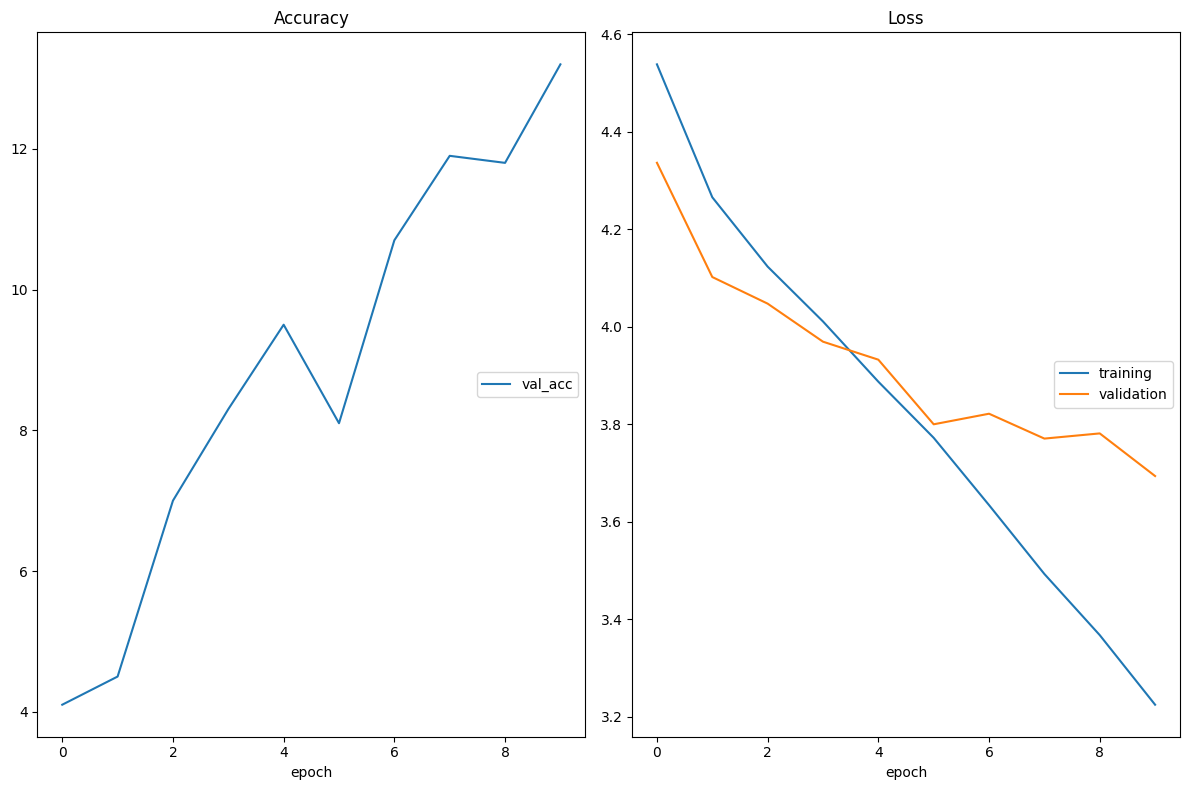

Epoch [10/10], Training Loss: 3.2243, Validation Loss: 3.6936, Validation Accuracy: 13.20%
New minimum validation loss: 3.693616. Saving model ...


In [16]:
training_loop(model, device, data_loaders, optimizer, criterion, num_epochs, model_save_path, transformations)

## Testing Your Model

In [17]:
from src.train import test_one_epoch

In [18]:
# Load best weights
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    
test_loss, test_accuracy = test_one_epoch(
    model, 
    device, data_loaders["test"], 
    optimizer, 
    criterion, 
    description="Testing", 
    transformations=transforms.Compose(common_transforms)
)

Testing: 100%|████████████████████████████████| 313/313 [01:50<00:00,  2.84it/s]


In [19]:
print ('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, 100 * test_accuracy))

Test Loss: 3.6656, Test Accuracy: 14.08%


## Examining the Network

In [1]:
from src.data import get_data_loaders
data_loaders = get_data_loaders(data_dir="./data", batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Get a batch of data
X, y = next(iter(data_loaders["train"]))

In [10]:
vgg16 = VGG16()

In [22]:
vgg16

VGG16(
  (model): Sequential(
    (layer1): Sequential(
      (conv_block): Sequential(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (layer2): Sequential(
      (conv_block): Sequential(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (conv_block): Sequential(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (layer4): Sequential(
      (conv_b

In [23]:
layers_lst = list()
def get_children(layer, level=0):
    global layers_lst
    named_children = list(layer.named_children())
    for name, child in named_children:
        is_leaf_node = len(list(child.named_children())) == 0
        layers_lst.append({"name": name, "layer": child, "level": level, "is_leaf_node": is_leaf_node})
        get_children(child, level+1)

In [24]:
get_children(vgg16.model)

In [25]:
out = X
for layer in layers_lst:
    print_message = layer["level"] * "\t" + "{0:15s}".format("(" + layer["name"]+ "),")
    if layer["is_leaf_node"]:
        out = layer["layer"](out)
        print_message += f", Output shape: {list(out.shape)}"
    print(print_message)

(layer1),      
	(conv_block),  
		(conv),        , Output shape: [32, 64, 224, 224]
		(batch_norm),  , Output shape: [32, 64, 224, 224]
		(relu),        , Output shape: [32, 64, 224, 224]
(layer2),      
	(conv_block),  
		(conv),        , Output shape: [32, 64, 224, 224]
		(batch_norm),  , Output shape: [32, 64, 224, 224]
		(relu),        , Output shape: [32, 64, 224, 224]
	(max_pool),    , Output shape: [32, 64, 112, 112]
(layer3),      
	(conv_block),  
		(conv),        , Output shape: [32, 128, 112, 112]
		(batch_norm),  , Output shape: [32, 128, 112, 112]
		(relu),        , Output shape: [32, 128, 112, 112]
(layer4),      
	(conv_block),  
		(conv),        , Output shape: [32, 128, 112, 112]
		(batch_norm),  , Output shape: [32, 128, 112, 112]
		(relu),        , Output shape: [32, 128, 112, 112]
	(max_pool),    , Output shape: [32, 128, 56, 56]
(layer5),      
	(conv_block),  
		(conv),        , Output shape: [32, 256, 56, 56]
		(batch_norm),  , Output shape: [32, 256, 56, 56]
		

In [16]:
# Model complexity - calculating the total number of parameters
trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
trainable_params

134309962

### Viparameterslize your network

You can visualize the architecture using netron.app. Execute following cell to create `resnet18_network.pt` file. Then, go to [Netron.app](https://netron.app/) and click on Open Model, and select the file that was generated.

In [ ]:
scripted = torch.jit.trace(vgg16, X)

In [ ]:
torch.jit.save(scripted, "visualization/vgg16_network.pt")

### Visualize The Computation Graph

In [ ]:
from torchviz import make_dot

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
A = vgg16(X)

In [ ]:
loss = criterion(A, y)

In [ ]:
make_dot(
    loss, 
    params=dict(list(vgg16.named_parameters())), 
    show_attrs=True, 
    show_saved=True
).render("visualization/vgg16_model", format="svg")